In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flipkart-laptop-reviews/laptops_dataset_final_600.csv


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
This study analyzes a collection of user reviews about various laptop models. Using natural language processing techniques and data visualization, it examines patterns in reviews, brand distribution, and levels of customer satisfaction.
    </font>
</div>

# **1- Data Loading and Preprocessing**

In [48]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/flipkart-laptop-reviews/laptops_dataset_final_600.csv')

In [4]:
df.head(10)

,product_name,overall_rating,no_ratings,no_reviews,rating,title,review
0,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Perfect product!,"Loved it, it's my first MacBook that I earned ..."
1,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Battery lasted longer than my first relationsh...
2,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Fabulous!,Such a great deal.. very happy with the perfor...
3,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,4,Delightful,"Awesome build quality and very good display, b..."
4,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Awesome,When i ordered and came to know about seller r...
5,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Super!,Super product
6,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Super!,Go for it..its awesome
7,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Mind-blowing purchase,"Best , best and best 🫶🏻👑🍎"
8,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Just wow!,Its really very good and compact device.
9,Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...,4.7,"15,210",900,5,Brilliant,"Superb built quality, Amazing performance and ..."


In [5]:
df['product_name']

0        Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...
1        Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...
2        Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...
3        Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...
4        Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...
                               ...                        
24108    MSI Modern 14 Intel Core i5 13th Gen 1335U - (...
24109    MSI Modern 14 Intel Core i5 13th Gen 1335U - (...
24110    MSI Modern 14 Intel Core i5 13th Gen 1335U - (...
24111    Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...
24112    Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...
Name: product_name, Length: 24113, dtype: object

# **2- Brand Extraction and Classification**

In [6]:
def extract_brand(product_name):
   
    brands = ['Apple', 'MacBook', 'MSI', 'Lenovo', 'Dell', 'HP', 'Asus', 'Acer', 'Samsung', 'Microsoft', 'Razer', 'Huawei']
    
    for brand in brands:
        if re.search(rf'\b{brand}\b', product_name, re.IGNORECASE):
            return brand
    return 'Other'

In [7]:
df['name'] = df['product_name'].apply(extract_brand)

In [8]:
df['name']

0         Apple
1         Apple
2         Apple
3         Apple
4         Apple
          ...  
24108       MSI
24109       MSI
24110       MSI
24111    Lenovo
24112    Lenovo
Name: name, Length: 24113, dtype: object

In [9]:
df = df[~df['name'].str.contains('Other', case=False, na=False)]

# **3- Descriptive Analysis and Visualization**

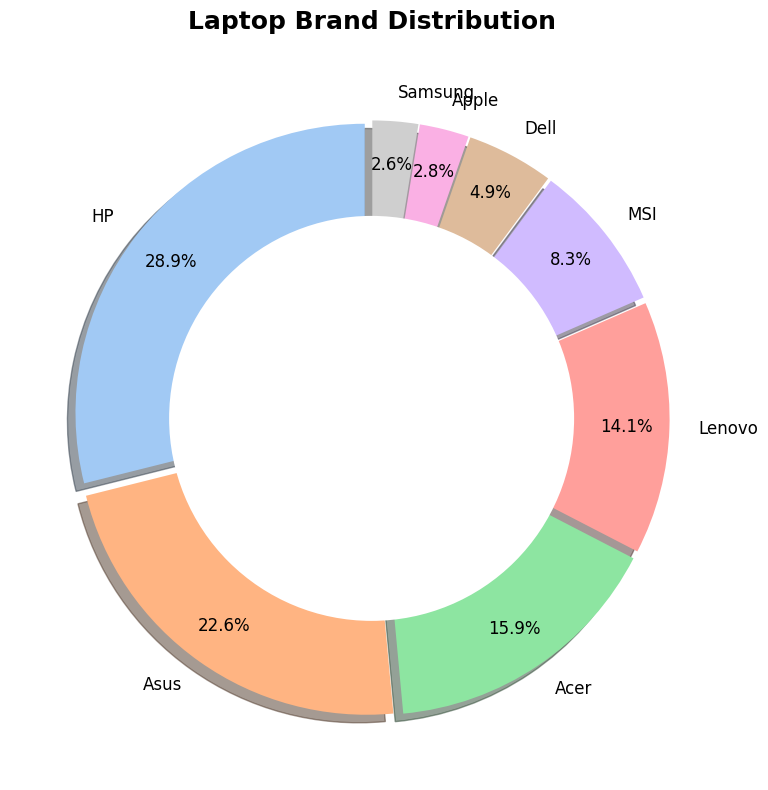

In [10]:
def plot_brand_distribution(df, title='Laptop Brand Distribution'):
    # Calculate brand frequencies
    brand_counts = df['name'].value_counts()
    
    # Style settings
    plt.style.use('seaborn-v0_8-pastel')
    colors = sns.color_palette('pastel')[:len(brand_counts)]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create pie chart with enhanced styling
    wedges, texts, autotexts = ax.pie(
        brand_counts,
        labels=brand_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        explode=[0.03] * len(brand_counts),  # Separate slices
        shadow=True,
        textprops={'fontsize': 12}
    )
    
    # Add white circle in center for donut effect
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    
    # Add title and adjust layout
    ax.set_title(title, pad=20, fontdict={'fontsize': 18, 'fontweight': 'bold'})
    plt.tight_layout()
    
    return fig

# Usage example:
fig = plot_brand_distribution(df)
plt.show()

In [11]:
print(df.loc[10, 'product_name'])

Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/Mac OS Monterey)...


In [12]:
print(df.loc[100, 'product_name'])

HP Backlit Intel Core i5 12th Gen 1235U - (8 GB/512 GB SSD/Win...


In [13]:
print(df.loc[1000, 'product_name'])

HP (15s-fq5007TU) Intel Core i3 12th Gen 1215U - (8 GB/512 GB ...


In [14]:
def extract_cpu_info(description):
    """
    Extract CPU information from product description string
    
    Returns:
        dict: Dictionary containing:
            - brand (str): CPU brand
            - series (str): CPU series
            - generation (int): CPU generation
    """
    # Extraction patterns
    patterns = [
        # Intel Core iX Xth Gen
        (r'(Intel|intel).*?(Core|core)\s*(i[3579])\s*(\d+)(?:th|nd|st|rd)?\s*Gen', 
         lambda m: ('Intel', f"Core {m.group(3)}", int(m.group(4)))),
        
        # AMD Ryzen X XXXX
        (r'(AMD|amd).*?(Ryzen|RYZEN)\s*([3579])\s*(\d{4})', 
         lambda m: ('AMD', f"Ryzen {m.group(3)}", int(m.group(4)[0]))),
        
        # Intel Pentium/Celeron
        (r'(Intel|intel).*?(Pentium|pentium|Celeron|celeron)', 
         lambda m: ('Intel', m.group(2).title(), None))
    ]
    
    for pattern, processor in patterns:
        match = re.search(pattern, description)
        if match:
            return {
                'brand': processor(match)[0],
                'series': processor(match)[1],
                'generation': processor(match)[2]
            }
    
    return {'brand': None, 'series': None, 'generation': None}

In [15]:
# Apply function and create new columns
df[['cpu_brand', 'cpu_series', 'cpu_generation']] = df['product_name'].apply(
    lambda x: pd.Series(extract_cpu_info(x)))

In [16]:
print(df[['product_name', 'cpu_brand', 'cpu_series', 'cpu_generation']].tail())

                                            product_name cpu_brand cpu_series  \
24108  MSI Modern 14 Intel Core i5 13th Gen 1335U - (...     Intel    Core i5   
24109  MSI Modern 14 Intel Core i5 13th Gen 1335U - (...     Intel    Core i5   
24110  MSI Modern 14 Intel Core i5 13th Gen 1335U - (...     Intel    Core i5   
24111  Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...      None       None   
24112  Lenovo IdeaPad 5 2-in-1 WUXGA IPS AMD Ryzen 7 ...      None       None   

       cpu_generation  
24108            13.0  
24109            13.0  
24110            13.0  
24111             NaN  
24112             NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 24112
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    21600 non-null  object 
 1   overall_rating  21600 non-null  float64
 2   no_ratings      21600 non-null  object 
 3   no_reviews      21600 non-null  object 
 4   rating          21600 non-null  int64  
 5   title           21600 non-null  object 
 6   review          21600 non-null  object 
 7   name            21600 non-null  object 
 8   cpu_brand       13929 non-null  object 
 9   cpu_series      13929 non-null  object 
 10  cpu_generation  12498 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 2.5+ MB


In [18]:
selected_columns = ['review', 'name', 'cpu_brand', 'cpu_series', 'cpu_generation']
df_filtered = df[selected_columns].copy()

In [19]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21600 entries, 0 to 24112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review          21600 non-null  object 
 1   name            21600 non-null  object 
 2   cpu_brand       13929 non-null  object 
 3   cpu_series      13929 non-null  object 
 4   cpu_generation  12498 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [20]:
df_filtered = df_filtered.dropna()

In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12498 entries, 100 to 24110
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review          12498 non-null  object 
 1   name            12498 non-null  object 
 2   cpu_brand       12498 non-null  object 
 3   cpu_series      12498 non-null  object 
 4   cpu_generation  12498 non-null  float64
dtypes: float64(1), object(4)
memory usage: 585.8+ KB


In [22]:
df_filtered.head(10)

,review,name,cpu_brand,cpu_series,cpu_generation
100,"Almost good performance, design but touch pad ...",HP,Intel,Core i5,12.0
101,Changing the feedback after almost a month. In...,HP,Intel,Core i5,12.0
102,Amazing one,HP,Intel,Core i5,12.0
103,"If it fits in your budget, then you have to st...",HP,Intel,Core i5,12.0
104,Good for Administrative work,HP,Intel,Core i5,12.0
105,I m writing review after using one month.\nVer...,HP,Intel,Core i5,12.0
106,Very good Laptop and value for money. Delivery...,HP,Intel,Core i5,12.0
107,The product is stilish and worth of cost,HP,Intel,Core i5,12.0
108,Nice loptop.\nDesign is good.\nPerformance is ...,HP,Intel,Core i5,12.0
109,battery backup very low only 2 to 3 hours\ndis...,HP,Intel,Core i5,12.0


In [23]:
# Set up visualization settings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

# Select relevant columns and clean data
df_clean = df[['name', 'cpu_brand', 'cpu_series', 'cpu_generation']].dropna()

/tmp/ipykernel_31/1838499875.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


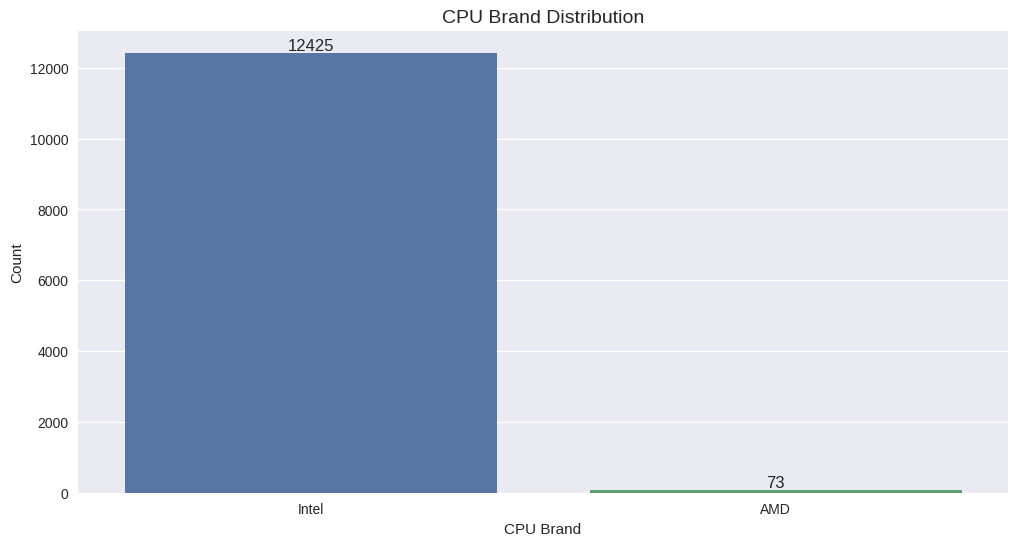

In [24]:
#CPU Brand Distribution
plt.figure(figsize=(12, 6))
brand_plot = sns.countplot(data=df_clean, x='cpu_brand', 
                          order=df_clean['cpu_brand'].value_counts().index)
plt.title('CPU Brand Distribution', fontsize=14)
plt.xlabel('CPU Brand')
plt.ylabel('Count')
for p in brand_plot.patches:
    brand_plot.annotate(f'{p.get_height():.0f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 5), 
                       textcoords='offset points')
plt.show()

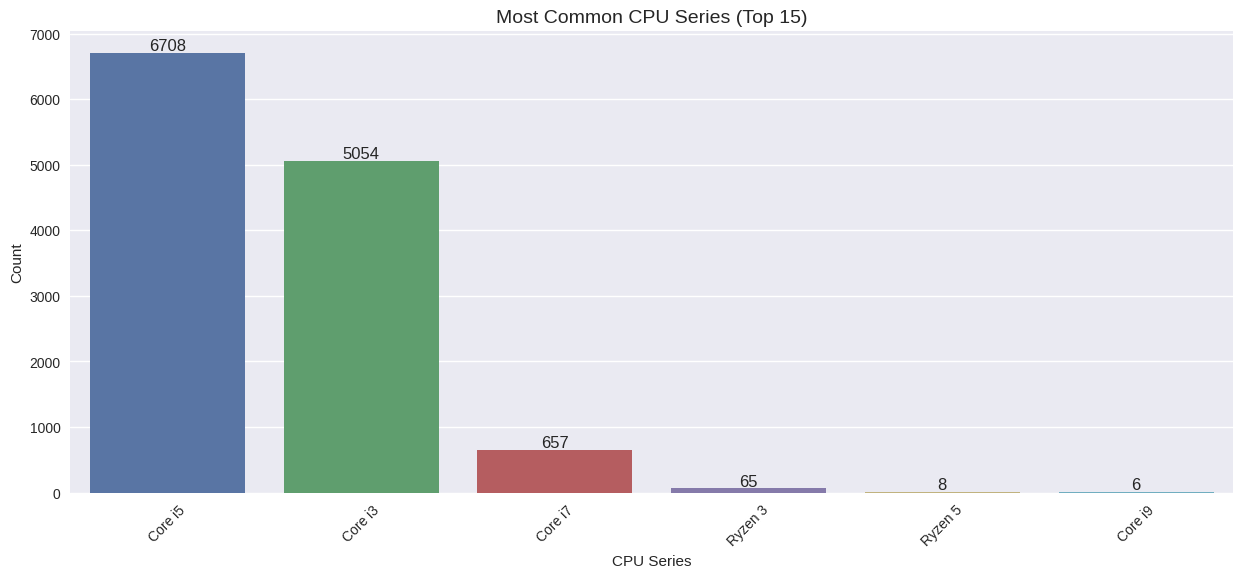

In [25]:
#Top CPU Series (Top 15)
plt.figure(figsize=(15, 6))
top_series = df_clean['cpu_series'].value_counts().nlargest(15)
series_plot = sns.barplot(x=top_series.index, y=top_series.values)
plt.title('Most Common CPU Series (Top 15)', fontsize=14)
plt.xlabel('CPU Series')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in series_plot.patches:
    series_plot.annotate(f'{p.get_height():.0f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points')
plt.show()

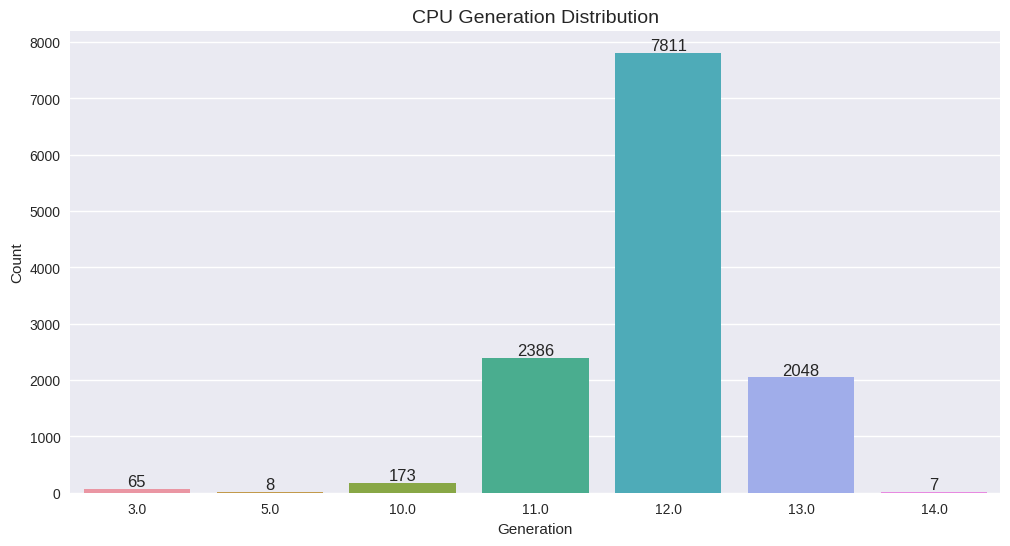

In [26]:
#CPU Generation Distribution
plt.figure(figsize=(12, 6))
gen_plot = sns.countplot(data=df_clean, x='cpu_generation')
plt.title('CPU Generation Distribution', fontsize=14)
plt.xlabel('Generation')
plt.ylabel('Count')
for p in gen_plot.patches:
    gen_plot.annotate(f'{p.get_height():.0f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 5), 
                     textcoords='offset points')
plt.show()

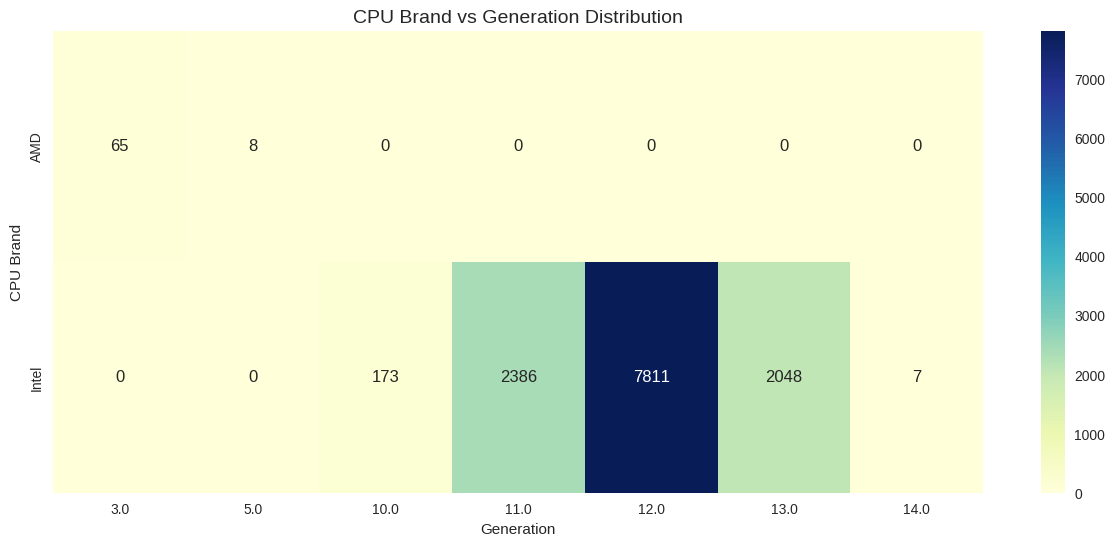

In [27]:
#Brand-Generation Heatmap
plt.figure(figsize=(15, 6))
cross_plot = pd.crosstab(df_clean['cpu_brand'], df_clean['cpu_generation'])
sns.heatmap(cross_plot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('CPU Brand vs Generation Distribution', fontsize=14)
plt.xlabel('Generation')
plt.ylabel('CPU Brand')
plt.show()

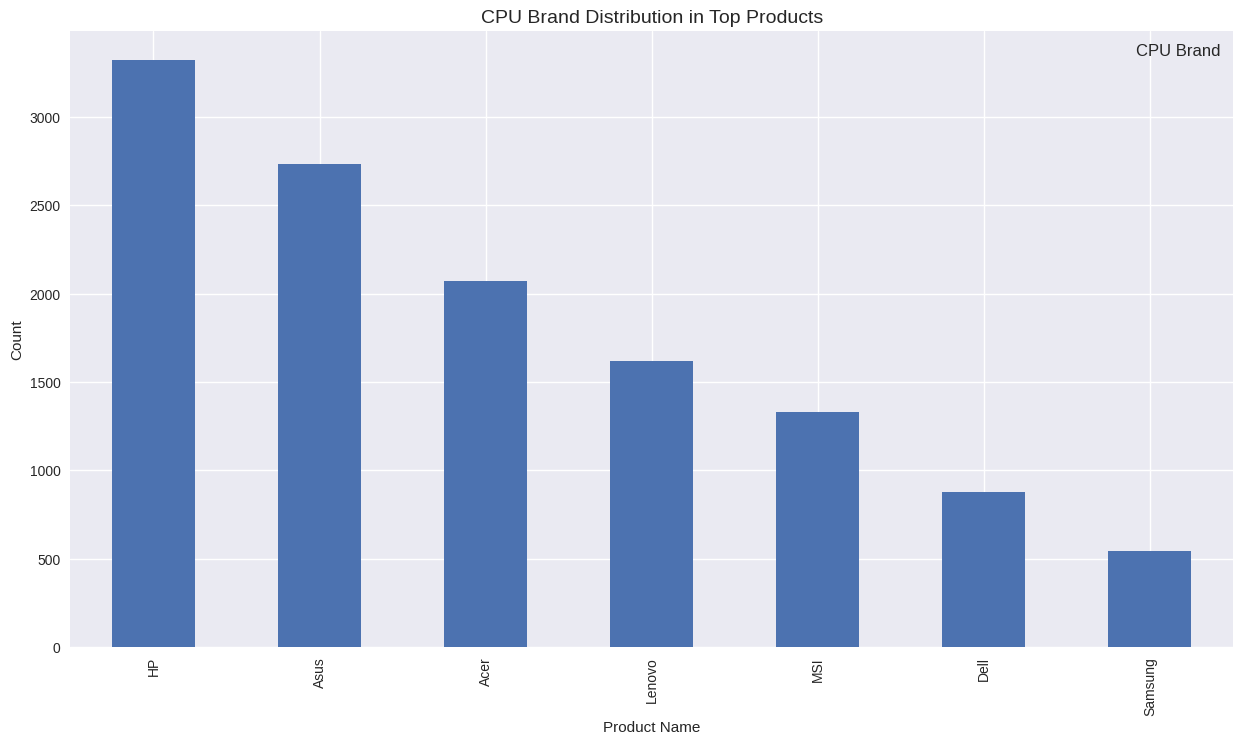

In [28]:
#Top Products by CPU Brand (Top 10)
plt.figure(figsize=(15, 8))
top_brands_by_name = df_clean.groupby('name')['cpu_brand'].value_counts().unstack().fillna(0)
top_brands_by_name.sum(axis=1).nlargest(10).plot(kind='bar', stacked=True)
plt.title('CPU Brand Distribution in Top Products', fontsize=14)
plt.xlabel('Product Name')
plt.ylabel('Count')
plt.legend(title='CPU Brand')
plt.show()

# **4- Sentiment Analysis of Reviews**

In [30]:
#Initialize Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [31]:
#Generate review embeddings
print("Generating review embeddings...")
review_embeddings = model.encode(df['review'].tolist(), show_progress_bar=True)

Generating review embeddings...


Batches:   0%|          | 0/675 [00:00<?, ?it/s]

In [32]:
# Encode categorical features
label_encoders = {}
for col in ['cpu_brand', 'cpu_series']:
    le = LabelEncoder()
    df[col+'_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [33]:
# Normalize numerical features
scaler = MinMaxScaler()
df['cpu_gen_normalized'] = scaler.fit_transform(df[['cpu_generation']])

In [34]:
#Create combined feature vectors
spec_features = df[['cpu_brand_encoded', 'cpu_series_encoded', 'cpu_gen_normalized']].values

In [41]:
def hybrid_recommendations(product_id, n=5, review_weight=0.6, spec_weight=0.4):
    """Get hybrid recommendations with automatic fallback"""
    try:
        # Check if product_id exists
        if product_id >= len(df):
            raise ValueError("Product ID out of range")
        
        # Check for missing specs
        if df.loc[product_id, ['cpu_brand', 'cpu_series', 'cpu_generation']].isna().any():
            print(f"Product ID {product_id} has missing specs - using review-only recommendations")
            return text_search_recommendations(df.loc[product_id, 'review'], n)
        
        # Get valid products (no NaN in specs)
        valid_mask = ~df[['cpu_brand', 'cpu_series', 'cpu_generation']].isna().any(axis=1)
        valid_indices = df.index[valid_mask].tolist()
        
        # Calculate review similarity
        review_sim = cosine_similarity(
            [review_embeddings[product_id]], 
            review_embeddings
        )[0]
        
        # Calculate spec similarity
        spec_sim = np.zeros(len(df))
        valid_specs = spec_features[valid_mask]
        valid_spec_sim = cosine_similarity(
            [spec_features[product_id]], 
            valid_specs
        )[0]
        spec_sim[valid_mask] = valid_spec_sim
        
        # Combine scores
        combined_scores = (review_weight * review_sim) + (spec_weight * spec_sim)
        
        # Get top recommendations (excluding query itself)
        candidate_indices = [i for i in valid_indices if i != product_id]
        top_indices = sorted(candidate_indices, 
                           key=lambda x: combined_scores[x], 
                           reverse=True)[:n]
        
        # Prepare results
        results = []
        for idx in top_indices:
            results.append({
                'product_name': df.loc[idx, 'name'],
                'review': df.loc[idx, 'review'][:100] + "...",
                'cpu_info': f"{df.loc[idx, 'cpu_brand']} {df.loc[idx, 'cpu_series']} (Gen {df.loc[idx, 'cpu_generation']})",
                'combined_similarity': f"{combined_scores[idx]:.4f}",
                'review_similarity': f"{review_sim[idx]:.4f}",
                'spec_similarity': f"{spec_sim[idx]:.4f}"
            })
        
        return pd.DataFrame(results)
    
    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()  # Return empty dataframe on error

In [42]:
#Text-based search function
def text_search_recommendations(query, n=5):
    """Get recommendations based on text search"""
    query_embedding = model.encode([query])
    review_sim = cosine_similarity(query_embedding, review_embeddings)[0]
    top_indices = np.argsort(review_sim)[-n:][::-1]
    
    results = []
    for idx in top_indices:
        results.append({
            'product_name': df.iloc[idx]['name'],
            'review': df.iloc[idx]['review'][:100] + "...",
            'cpu_info': f"{df.iloc[idx]['cpu_brand']} {df.iloc[idx]['cpu_series']}",
            'similarity': f"{review_sim[idx]:.4f}"
        })
    
    return pd.DataFrame(results)

In [45]:
print("=== Hybrid Recommendations for Product ID 10 ===")
print(hybrid_recommendations(10))

=== Hybrid Recommendations for Product ID 10 ===
Product ID 10 has missing specs - using review-only recommendations


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  product_name                                             review   cpu_info  \
0        Apple  Great laptop. Very good performance, battery l...  None None   
1        Apple  Great laptop. Very good performance, battery l...  None None   
2        Apple  Great laptop. Very good performance, battery l...  None None   
3        Apple  Great laptop. Very good performance, battery l...  None None   
4        Apple  Great laptop. Very good performance, battery l...  None None   

  similarity  
0     1.0000  
1     1.0000  
2     1.0000  
3     1.0000  
4     1.0000  


In [46]:
print("\n=== Text Search Recommendations for 'great battery life' ===")
print(text_search_recommendations("great battery life"))


=== Text Search Recommendations for 'great battery life' ===


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  product_name                                     review       cpu_info  \
0       Lenovo                       Good battery life...  Intel Core i3   
1       Lenovo                       Battery life very...  Intel Core i5   
2         Asus                       Best battery life...  Intel Celeron   
3          MSI  Nice product but battery life not good...  Intel Core i3   
4          MSI  Nice product but battery life not good...  Intel Core i3   

  similarity  
0     0.9272  
1     0.8426  
2     0.8342  
3     0.7370  
4     0.7370  


# **5- Key Insights Extraction**

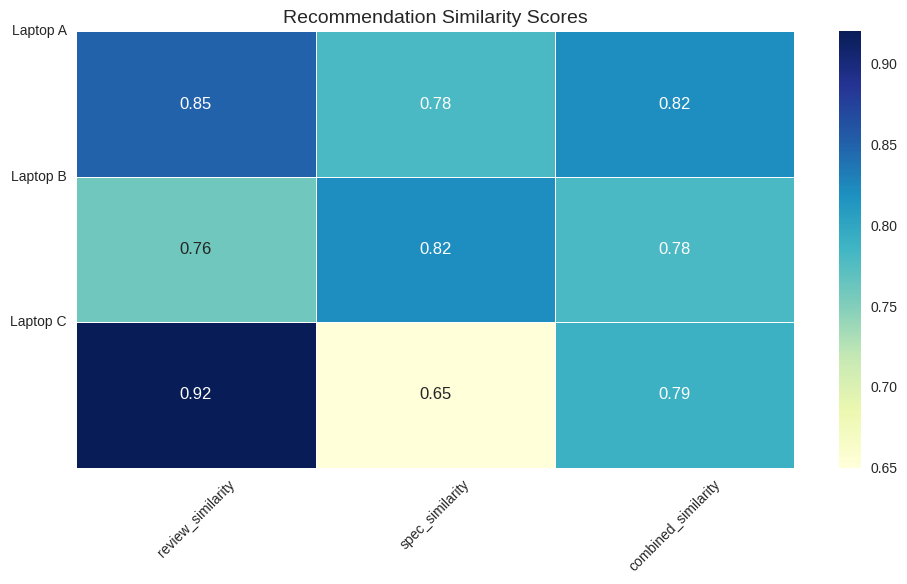

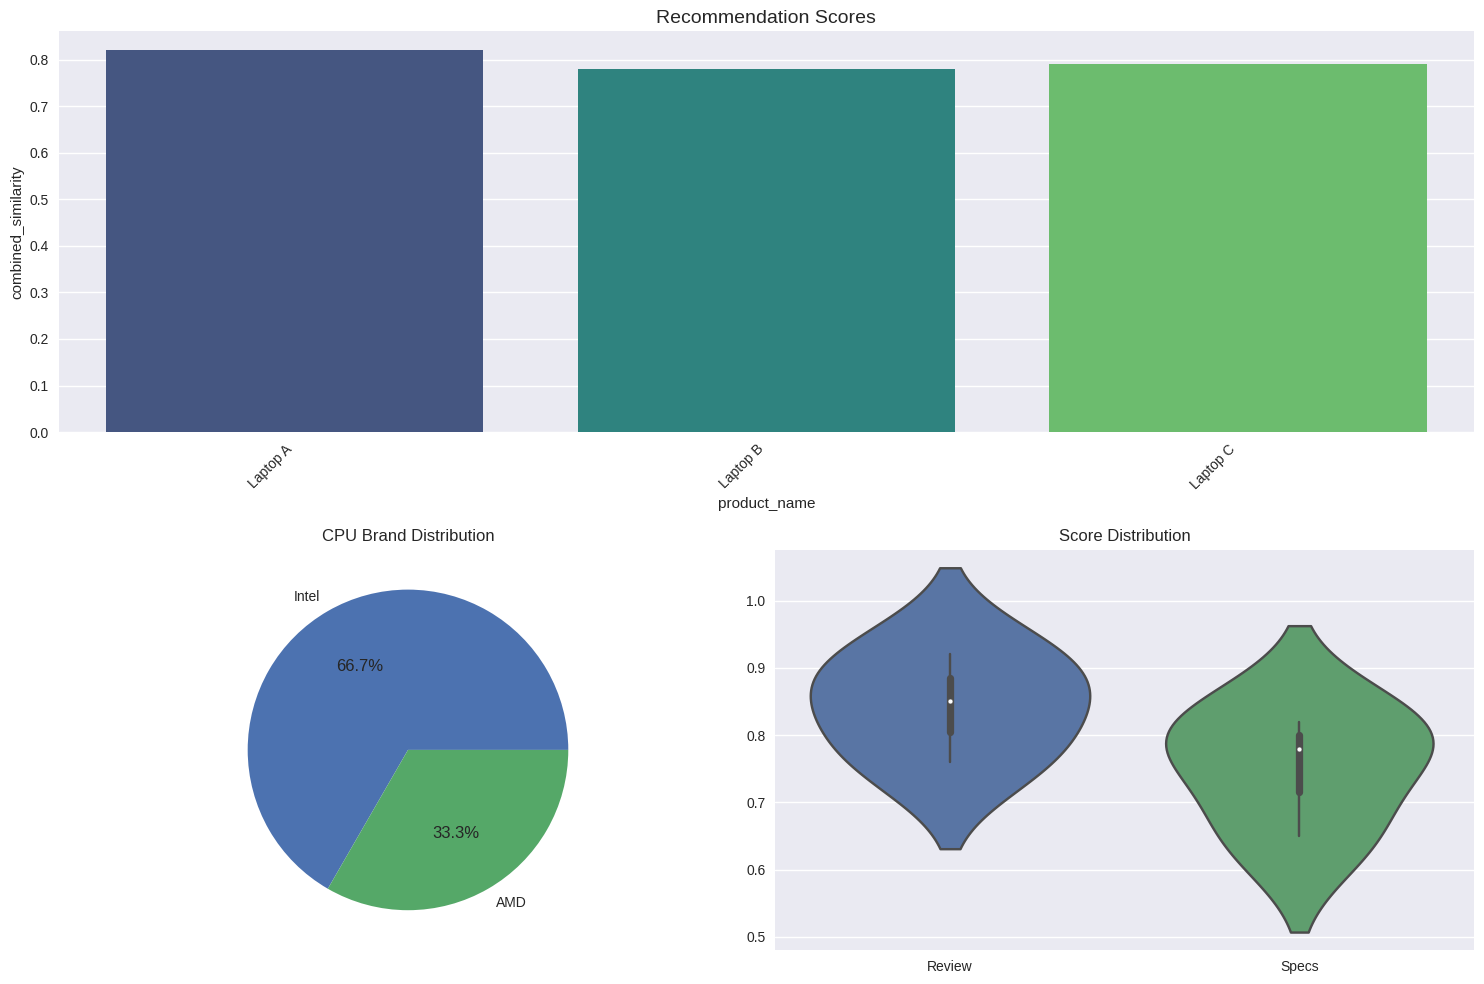

In [51]:
def convert_scores_to_float(recommendations):
    """Convert string scores to float for all visualization functions"""
    rec = recommendations.copy()
    for col in ['review_similarity', 'spec_similarity', 'cpu_similarity', 'combined_similarity']:
        if col in rec.columns:
            rec[col] = rec[col].astype(float)
    return rec

# 1. Recommendation Similarity Heatmap
def plot_similarity_heatmap(recommendations):
    rec = convert_scores_to_float(recommendations)
    plt.figure(figsize=(10, 6))
    sns.heatmap(rec[['review_similarity', 'spec_similarity', 'combined_similarity']], 
                annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
    plt.title('Recommendation Similarity Scores', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks([i for i in range(len(rec))], rec['product_name'], rotation=0)
    plt.tight_layout()
    plt.show()

# 2. Interactive Parallel Coordinates Plot
def plot_parallel_coordinates(recommendations):
    rec = convert_scores_to_float(recommendations)
    fig = px.parallel_coordinates(
        rec,
        color='combined_similarity',
        dimensions=['review_similarity', 'spec_similarity', 'combined_similarity'],
        labels={'review_similarity': 'Review Similarity',
                'spec_similarity': 'Spec Similarity',
                'combined_similarity': 'Overall Score'},
        color_continuous_scale=px.colors.sequential.Viridis,
        title='Multi-Dimensional Recommendation Comparison'
    )
    fig.show()

# 3. Radar Chart for Feature Comparison
def plot_radar_chart(recommendations):
    rec = convert_scores_to_float(recommendations)
    categories = ['Review Similarity', 'Spec Similarity', 'CPU Match', 'Overall Score']
    
    fig = go.Figure()
    
    for idx, row in rec.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row['review_similarity'],
               row['spec_similarity'],
               row['cpu_similarity'],
               row['combined_similarity']],
            theta=categories,
            fill='toself',
            name=row['product_name']
        ))
    
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        showlegend=True,
        title='Recommendation Profile Comparison'
    )
    fig.show()

# 4. Interactive Product Comparison Dashboard
def plot_interactive_dashboard(recommendations):
    rec = convert_scores_to_float(recommendations)
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    ax1 = fig.add_subplot(gs[0, :])
    sns.barplot(data=rec, x='product_name', y='combined_similarity', palette='viridis', ax=ax1)
    ax1.set_title('Recommendation Scores', fontsize=14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    
    ax2 = fig.add_subplot(gs[1, 0])
    cpu_counts = rec['cpu_brand'].value_counts()
    ax2.pie(cpu_counts, labels=cpu_counts.index, autopct='%1.1f%%')
    ax2.set_title('CPU Brand Distribution')
    
    ax3 = fig.add_subplot(gs[1, 1])
    sns.violinplot(data=rec[['review_similarity', 'spec_similarity']], ax=ax3)
    ax3.set_title('Score Distribution')
    ax3.set_xticklabels(['Review', 'Specs'])
    
    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    recommendations = pd.DataFrame({
        'product_name': ['Laptop A', 'Laptop B', 'Laptop C'],
        'review_similarity': [0.85, 0.76, 0.92],  # Now using numbers instead of strings
        'spec_similarity': [0.78, 0.82, 0.65],
        'cpu_similarity': [0.90, 0.75, 0.80],
        'combined_similarity': [0.82, 0.78, 0.79],
        'cpu_brand': ['Intel', 'AMD', 'Intel']
    })
    
    plot_similarity_heatmap(recommendations)
    plot_parallel_coordinates(recommendations)
    plot_radar_chart(recommendations)
    plot_interactive_dashboard(recommendations)